TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise

Your name <br>
Your e-mail

February 2022

---


This is the template for the image recognition exercise. <Br>
Some **general instructions**:
 - write a clear *report*, understandable for an unspecialized reader: define shortly the concepts and explain the phases you use
    - use the Markdown feature of the notebook for larger explanations
 - return your output as a working Jupyter notebook
 - name your file as MLPR22_exercise_your_surname.ipynb
 - write easily readable code with comments     
     - if you exploit some code from web, provide a reference
     - avoid redundant code! Exploit the relevant parts and modify the code for your purposes to produce only what you need 
 - it is ok to discuss with a friend about the assignment. But it is not ok to copy someone's work. Everyone should submit their own implementation

**Deadline 21st of March at 23:59**
- No extension granted, unless you have an extremely justified reason. In such case, ask for extension well in advance!
- Start now, do not leave it to the last minute. This exercise will need some labour!
- If you encounter problems, Google first and if you can’t find an answer, ask for help
    - pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives 4 points, i.e. the total score is 34 points.

From the template below, you can see how many exercise points can be acquired from each task. Exam points are given according to the table below: <br>
<br>
7-8 exercise points: 1 point <br>
9-10 exercise points: 2 points <br>
11-12 exercise points: 3 points <br>
13-14 exercise points: 4 points <br>
<br>
To pass the exercise, you need at least 7 exercise points, distributed somewhat evenly into tasks (you can't just implement Introduction, Data preparation and Feature extraction and leave the left undone!) <Br>        

## Introduction

Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?

Images: https://unsplash.com/

## Data preparation

In [1]:
# gather all packages needed here
import numpy as np
from itertools import groupby
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from skimage.color import rgb2gray
from skimage import img_as_ubyte as eight_bit
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler
from google.colab import files
import cv2

In [2]:
uploaded = files.upload()

Saving pebbles.txt to pebbles.txt
Saving sky.txt to sky.txt
Saving trees.txt to trees.txt


Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level to 8 levels
- make data augmentation: flip each image horizontally to increase the number of examples in the data

In [3]:
def process_images(location, x, y):
    images = []
    gray_images = []
    urls = np.loadtxt(location, dtype='U150')
    div = 64
    for i in range(len(urls)):
        try:
            image = io.imread(urls[i])
            resized = resize(image, (x, y))
            images.append(resized)
            gray_img = rgb2gray(resized)
            gray_img = eight_bit(gray_img)
            gray_img = gray_img // div * div + div // 2
            gray_images.append(gray_img)
        except:
            print("Error while loading images.")
    return images, gray_images


In [4]:
pebbles_images, pebbles_gray = process_images('pebbles.txt', 250, 250)
sky_images, sky_gray = process_images('sky.txt', 250, 250)
trees_images, trees_gray = process_images('trees.txt', 250, 250)

In [5]:
pebbles_flip = [cv2.flip(img, 1) for img in pebbles_images]
pebbles_gray_flip = [cv2.flip(img, 1) for img in pebbles_gray]
sky_flip = [cv2.flip(img, 1) for img in sky_images]

sky_gray_flip = [cv2.flip(img, 1) for img in sky_gray]
trees_flip = [cv2.flip(img, 1) for img in trees_images]
trees_gray_flip = [cv2.flip(img, 1) for img in trees_gray]

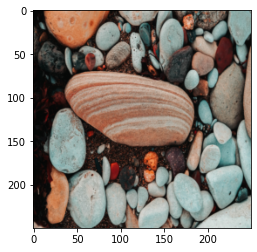

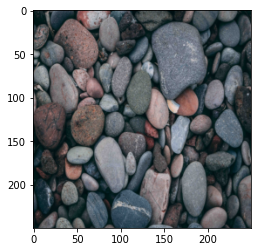

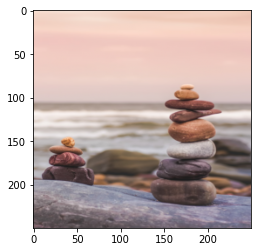

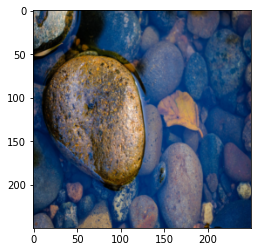

In [6]:
for i in range(0,4):
    plt.imshow(pebbles_images[i])
    plt.show()

In [7]:


pebbles = np.concatenate([pebbles_images, pebbles_flip])
sky = np.concatenate([sky_images, sky_flip])
trees = np.concatenate([trees_images, trees_flip])

pebbles_gray = np.concatenate([np.array(pebbles_gray), np.array(pebbles_gray_flip)])
sky_gray = np.concatenate([np.array(sky_gray), np.array(sky_gray_flip)])
trees_gray = np.concatenate([np.array(trees_gray), np.array(trees_gray_flip)])

In [8]:
print(pebbles.shape)

(120, 250, 250, 3)


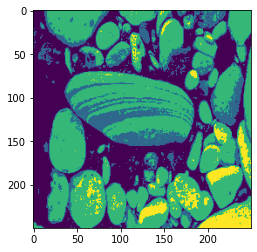

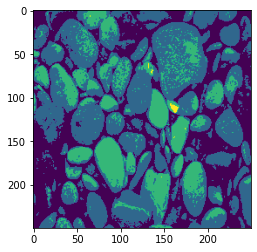

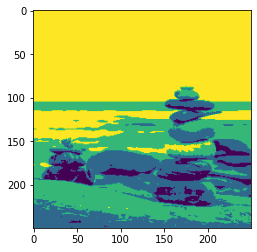

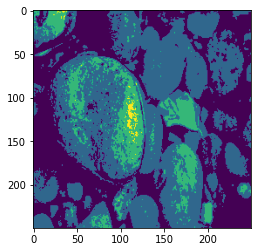

In [9]:
for i in range(0,4):
    plt.imshow(pebbles_gray[i])
    plt.show()

## Feature extraction

### First order texture measures (6 features)

- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [10]:
def first_order_texture_measures(images):
    
    r = images[:,:,:,0] 
    g = images[:,:,:,1] 
    b = images[:,:,:,2] 

    # calculate mean
    r_mean = np.mean(r, axis=(1,2)) 
    g_mean = np.mean(g, axis=(1,2)) 
    b_mean = np.mean(b, axis=(1,2)) 

    # calculate variance
    r_var = np.var(r, axis=(1,2)) 
    g_var = np.var(g, axis=(1,2)) 
    b_var = np.var(b, axis=(1,2)) 

    features = np.hstack([r_mean[:, None], g_mean[:, None], b_mean[:, None],
                      r_var[:, None], g_var[:, None], b_var[:, None]])
    
    return features

In [11]:
def make_df(data, label):
    df = pd.DataFrame(data)
    df['label'] = label
    return df

In [12]:
pebble_features = first_order_texture_measures(pebbles)
sky_features = first_order_texture_measures(sky)
tree_features = first_order_texture_measures(trees)

In [13]:
pebble_df = make_df(pebble_features,"pebbles")
sky_df = make_df(sky_features,"sky")
tree_df = make_df(tree_features,"trees")

In [14]:
rgb_data = pd.concat([pebble_df, sky_df, tree_df])
rgb_data = rgb_data.reset_index(drop=True)

In [15]:
rgb_data

,0,1,2,3,4,5,label
0,0.473123,0.432471,0.394367,0.062771,0.062632,0.059804,pebbles
1,0.320800,0.338638,0.356080,0.037382,0.026321,0.028325,pebbles
2,0.718605,0.630016,0.613301,0.054048,0.044730,0.041666,pebbles
3,0.265755,0.312455,0.387910,0.049812,0.020809,0.020141,pebbles
4,0.216430,0.203707,0.193730,0.010569,0.010345,0.011244,pebbles
...,...,...,...,...,...,...,...
355,0.401961,0.399152,0.372820,0.059534,0.056833,0.065690,trees
356,0.361063,0.393332,0.381462,0.057793,0.052139,0.053872,trees
357,0.456281,0.442115,0.441110,0.046021,0.048715,0.051904,trees
358,0.297977,0.270303,0.218379,0.041833,0.043995,0.044219,trees


### Second order texture measures (10 features)

- Calculate feature values for each following feature for each image in the prepared data set:
- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - calculate the "correlation" feature using the GLC matrix
        - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
    - explain your choice for the distances
- Gray-Level-Run-Length (GLRL) features (6 features) **(2 p)**
    - Calculate the following three features in horizontal and vertical direction
        - Use the given function for Gray-Level-Run-Length (GLRL) matrix
        - Implement the following run-length features using the GLRL matrix
            - Short-Run emphasis
            - Long-run emphasis
            - Run percentage
        - Test your implementation with the given toy image

In [16]:
def gray_features(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]): 
        
        df = pd.DataFrame()
        img = dataset[image, :,:]
        distance1 = [1, 2]
        distance2 = [3, 4]

        ver_angle = [0]
        hor_angle = [np.pi/2]

        glcm_ver_angle1 = greycomatrix(img, distances = distance1, angles = ver_angle)
        glcm_ver_corr1 = greycoprops(glcm_ver_angle1, 'correlation')[0]
        df['6'] = glcm_ver_corr1 

        glcm_ver_angle2 = greycomatrix(img, distances = distance2, angles = ver_angle)
        glcm_ver_corr2 = greycoprops(glcm_ver_angle1, 'correlation')[0]
        df['7'] = glcm_ver_corr2

        glcm_hor_angle1 =  greycomatrix(img, distances = distance1, angles = hor_angle)
        glcm_hor_corr1 = greycoprops(glcm_hor_angle1, 'correlation')[0]
        df['8'] = glcm_hor_corr1

        glcm_hor_angle2 =  greycomatrix(img, distances = distance2, angles = hor_angle)
        glcm_hor_corr2 = greycoprops(glcm_hor_angle2, 'correlation')[0]
        df['9'] = glcm_hor_corr2 

        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [17]:
pebble_gray_features = gray_features(pebbles_gray)
sky_gray_features = gray_features(sky_gray)
tree_gray_features = gray_features(trees_gray)


In [18]:
pebble_gray_df = make_df(pebble_gray_features, 'pebbles')
sky_gray_df = make_df(sky_gray_features, 'sky')
tree_gray_df = make_df(tree_gray_features, 'trees')

gray_data = pd.concat([pebble_gray_df, sky_gray_df, tree_gray_df])
gray_data = gray_data.reset_index(drop=True)

In [31]:
all_data = rgb_data.join(gray_data, lsuffix="_left")

In [32]:
all_data =  all_data.drop(['label_left'], axis=1)

In [33]:
all_data

,0,1,2,3,4,5,6,7,8,9,label
0,0.473123,0.432471,0.394367,0.062771,0.062632,0.059804,0.903544,0.903544,0.919927,0.786488,pebbles
1,0.320800,0.338638,0.356080,0.037382,0.026321,0.028325,0.837959,0.837959,0.868692,0.697255,pebbles
2,0.718605,0.630016,0.613301,0.054048,0.044730,0.041666,0.982034,0.982034,0.949941,0.872901,pebbles
3,0.265755,0.312455,0.387910,0.049812,0.020809,0.020141,0.848026,0.848026,0.881054,0.759762,pebbles
4,0.216430,0.203707,0.193730,0.010569,0.010345,0.011244,0.653952,0.653952,0.711871,0.423793,pebbles
...,...,...,...,...,...,...,...,...,...,...,...
355,0.401961,0.399152,0.372820,0.059534,0.056833,0.065690,0.929760,0.929760,0.948065,0.908242,trees
356,0.361063,0.393332,0.381462,0.057793,0.052139,0.053872,0.906339,0.906339,0.932683,0.878670,trees
357,0.456281,0.442115,0.441110,0.046021,0.048715,0.051904,0.993019,0.993019,0.991241,0.977909,trees
358,0.297977,0.270303,0.218379,0.041833,0.043995,0.044219,0.845573,0.845573,0.906254,0.837911,trees


In [22]:
all_data.columns

Index([0, 1, 2, 3, 4, 5, '6', '7', '8', '9', 'label'], dtype='object')

In [34]:
from sklearn.utils import shuffle

all_data = shuffle(all_data)
all_data = all_data.reset_index(drop=True)

Gather your features into an input array X, and the image classes into an output array y. Assign an image id for each image so that the original and flipped image have the same id. Standardize the feature values in X.

In [36]:
X = all_data.drop(['label'], axis=1)
y = all_data['label']

# Standardize the feature values in X
scaler = StandardScaler()
X = scaler.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [37]:
# Grey-Level-Run-Length-Matrix

def glrlm(image, levels, angle):
    if angle==0: # horizontal        
        runs=image.shape[1]
        glrl_matrix=np.zeros([levels,runs])

        for row in range(0,image.shape[0]):
            onerow=image[row,:]
            counts=[(i, len(list(g))) for i, g in groupby(onerow)]
            for count in counts:
                glrl_matrix[count[0],count[1]-1]=glrl_matrix[count[0],count[1]-1]+1

    if angle==90: # vertical
        runs=image.shape[0]
        glrl_matrix=np.zeros([levels,runs])

        for column in range(0,image.shape[1]):
            onecolumn=image[:,column]
            counts=[(i, len(list(g))) for i, g in groupby(onecolumn)]
            for count in counts:
                glrl_matrix[count[0],count[1]-1]=glrl_matrix[count[0],count[1]-1]+1
        
    return(glrl_matrix)      

In [38]:
# G_m = gray-level-run-length-matrix
# Np = the number of pixels in the image
def emphasis(G_m, Np):
    SRE = np.sum(np.square(G_m))/Np
    LRE = np.sum(np.square(G_m.sum(axis=0)))/Np
    RP = np.sum(np.square(G_m.sum(axis=1)))/Np
    return(SRE, LRE, RP)

In [39]:
# test the glrlm function with a toy example
toy_image=np.array([[1,1,1,2],[2,0,0,1],[1,0,2,2],[0,0,0,0]])

toy_GLRLM_0=glrlm(toy_image,3, 0)
toy_GLRLM_90=glrlm(toy_image,3, 90)

print('GLRL matrix for 0 degrees:')
print(toy_GLRLM_0)
print('GLRL matrix for 90 degrees:')
print(toy_GLRLM_90)

GLRL matrix for 0 degrees:
[[1. 1. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]]
GLRL matrix for 90 degrees:
[[4. 0. 1. 0.]
 [5. 0. 0. 0.]
 [4. 0. 0. 0.]]


In [40]:
# test your emphasis function in 0 direction
toy_SRE_0, toy_LRE_0, toy_RP_0=emphasis(toy_GLRLM_0, 16)
print('SRE:', np.round(toy_SRE_0, 3))
print('LRE:', np.round(toy_LRE_0, 3))
print('RP:', np.round(toy_RP_0, 3))

SRE: 0.812
LRE: 1.938
RP: 1.688


In [41]:
# test the emphasis function in 90 direction
toy_SRE_90, toy_LRE_90, toy_RP_90=emphasis(toy_GLRLM_90, 16)
print('SRE:', np.round(toy_SRE_90, 3))
print('LRE:', np.round(toy_LRE_90, 3))
print('RP:', np.round(toy_RP_90, 3))

SRE: 3.625
LRE: 10.625
RP: 4.125


## Feature relationships

Make illustrations of the feature relationships, and discuss the results **(1 p)**
- Pairplot 
    - Which feature pairs possess roughly linear dependence?
- PCA
    - Can you see any clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.


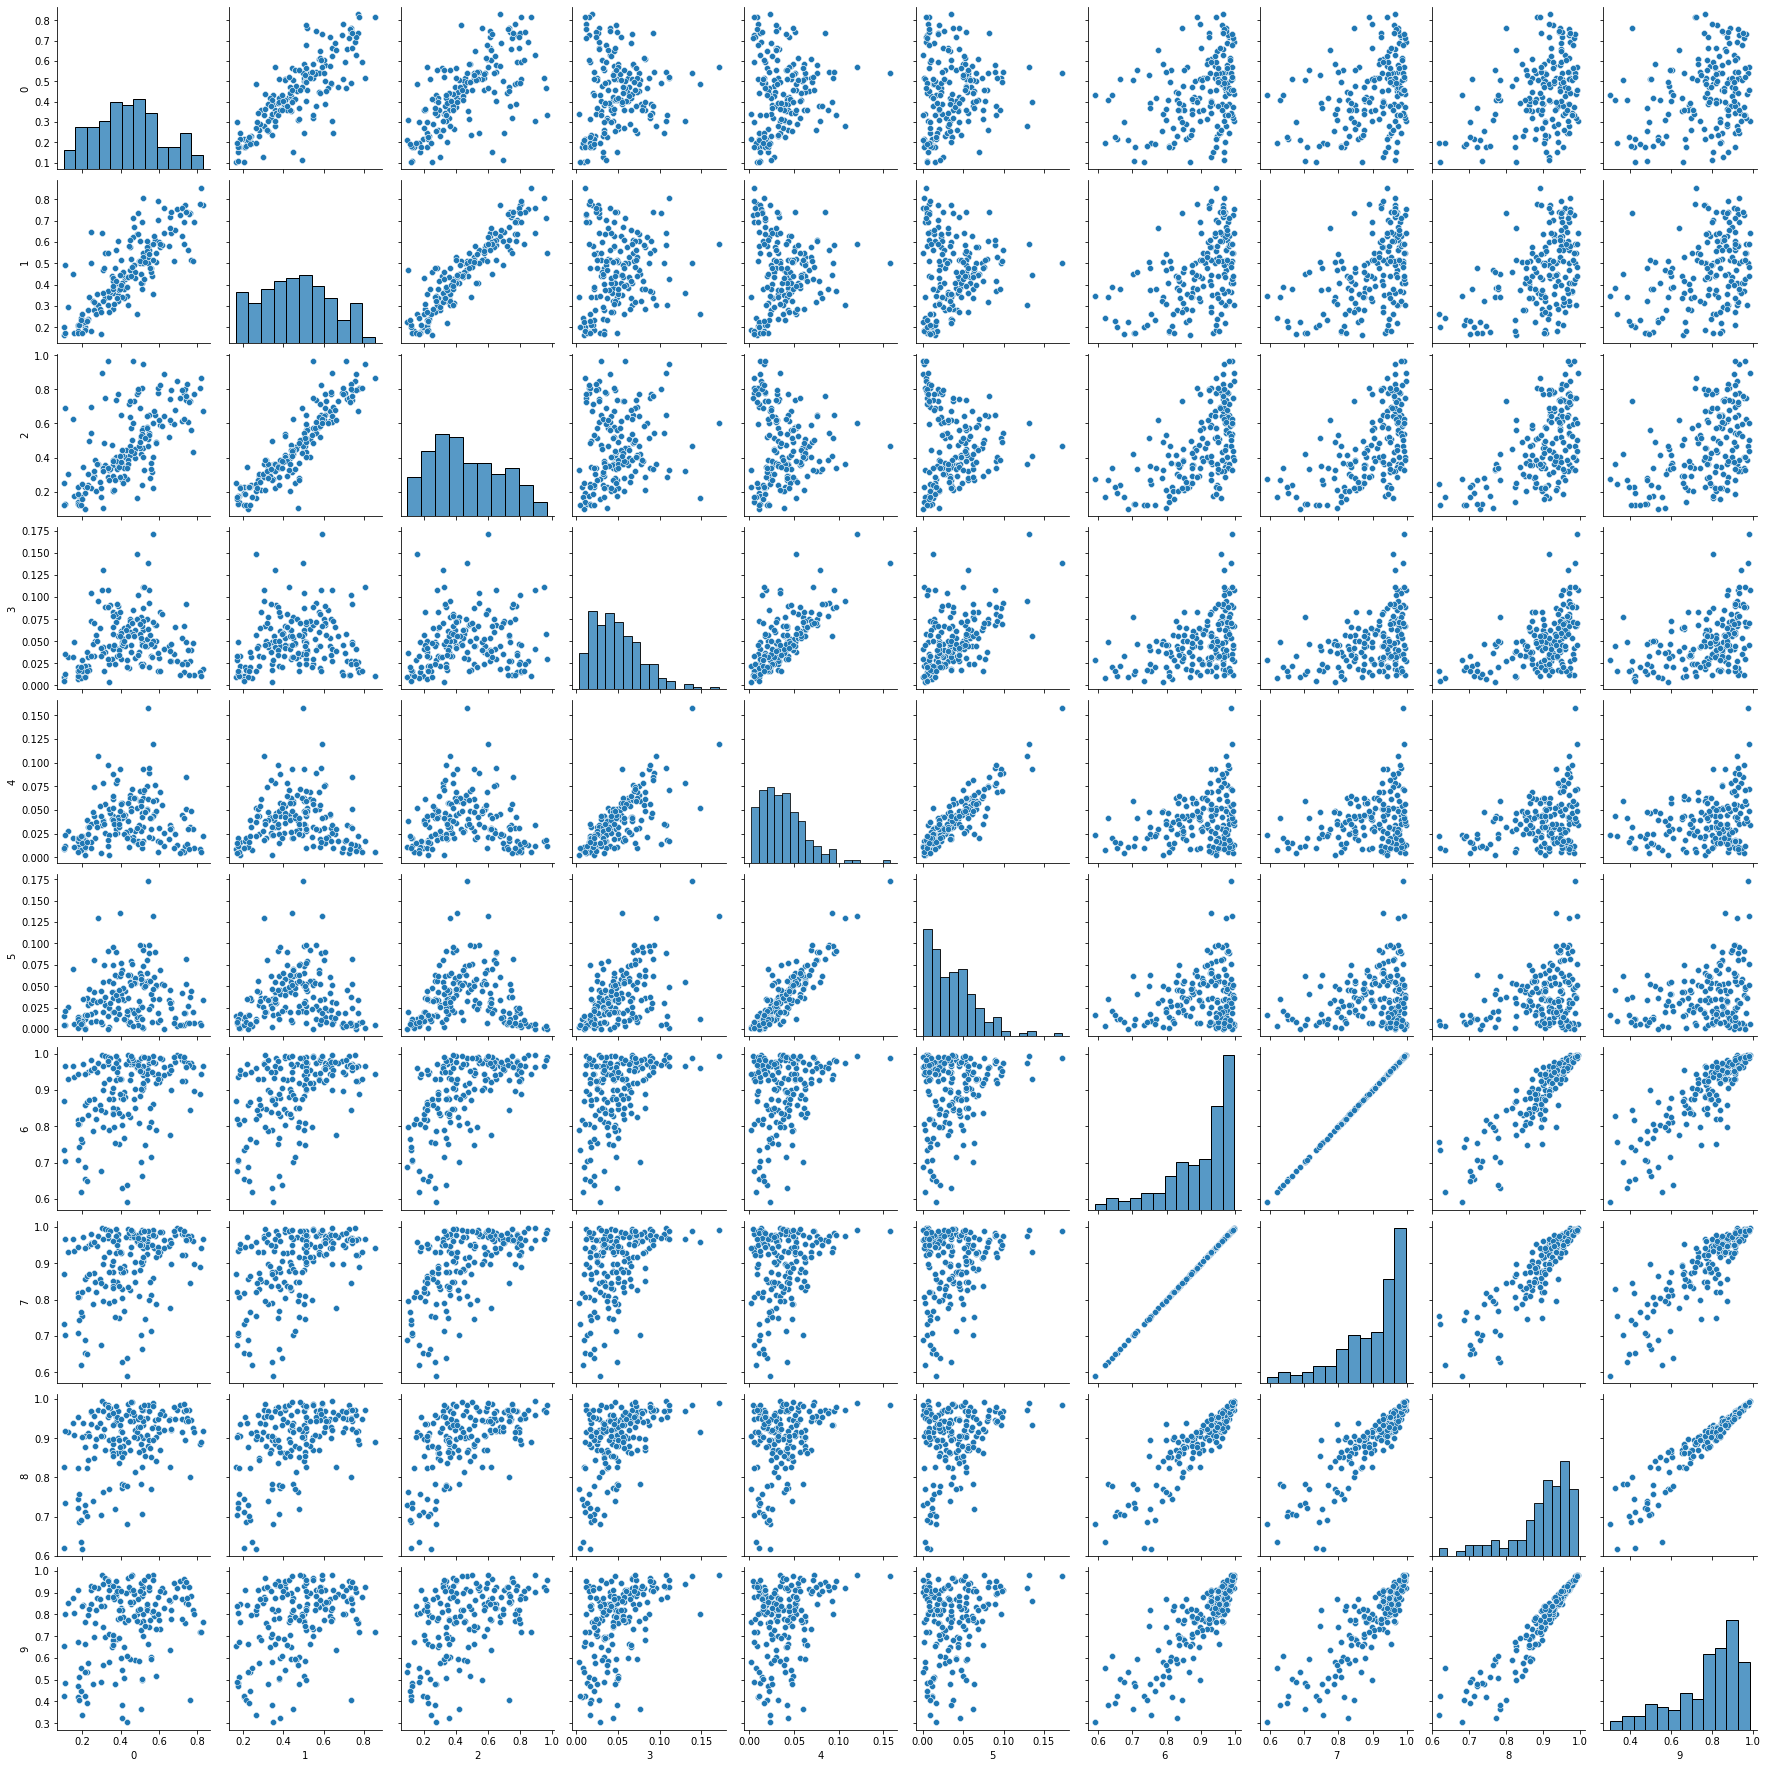

In [ ]:
#Make illustrations of the feature relationships, and discuss the results **(1 p)**
#Pairplot 
#Which feature pairs possess roughly linear dependence
#PCA
#Can you see any clusters in PCA

def pairplot(df):    
    sns.pairplot(df)
    plt.show()

pairplot(all_data)




In [42]:
def make_color_group(data):
    # Utility function to make color groups for plots
    # Values are hard coded for this exercise to: honey, light and bird.
    group = []
    for i in range(len(data)):
        if data[i] == 'pebbles':
            group.append(1)
        if data[i] == 'sky':
            group.append(2)
        if data[i] == 'trees':
            group.append(3)
    return group


In [43]:
group = make_color_group(y)

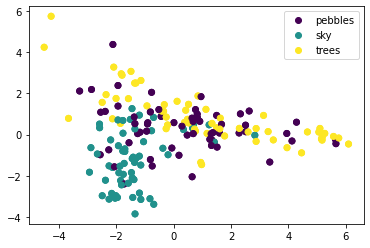

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=group)
plt.legend(handles=plot.legend_elements()[0], labels=["pebbles","sky","trees"])
plt.show()

In [146]:
Xt.shape

(360, 3)

In [147]:
X.shape

(360, 10)

In [47]:
y.shape

(360,)

In [48]:
len(group)

360

## Build the classifiers and estimate their performance

Build the classifiers and estimate their perfomance. Use LeaveOneGroupOut or GroupKFold cross validator (image id as group indicator).
- k Nearest Neighbors classifier **(1 p)** 
    - optimize the hyperparameter (k) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix
- Regularized linear model with Ridge regression **(1 p)**
    - optimize the hyperparameter (alpha) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

- Multi-layer perceptron MLP **(1 p)**
    - build the classifier. Use:
        - 1 hidden layer
        - solver for weight optimization: stochastic gradient-based optimizer ('adam')
        - activation function for the hidden layer: rectified linear unit function ('relu')
        - Early stop
    - optimize the number of neurons in the hidden layer and select the best model for the classifier
    - use Early stop committee, i.e. after selecting the model, calculate the prediction for the test data several times with different sampling of the training data. The members of the committee vote for the predicted class of the test sample. Use 50% of the training data for validation (algorithm terminates the training when validation score is not improving)
    - estimate the performance of the classifier with nested cross validation
- Discuss your results **(1 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?
    - How do you expect the models will perform with unseen data?

In [145]:
y.shape

(360,)

In [122]:
# used as a reference code from this url: https://stackoverflow.com/questions/60996995/use-groupkfold-in-nested-cross-validation-using-sklearn

from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut

pred_y = []
true_y = []

model = KNeighborsClassifier()
p_grid = {'n_neighbors':  np.arange(1, 31)}

inner_CV = LeaveOneGroupOut()
outer_CV = LeaveOneGroupOut()

for train_index, test_index in outer_CV.split(Xt, y, groups=group):
    X_tr, X_tt = Xt[train_index,:], Xt[test_index,:]
    y_tr, y_tt = y[train_index], y[test_index]

    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_CV)
    clf.fit(X_tr,y_tr,groups=y_tr)

    pred = clf.predict(X_tt)   
    pred_y.extend(pred)
    true_y.extend(y_tt)

In [123]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y, pred_y))

0.3416666666666667


In [124]:
print(confusion_matrix(y, pred_y))

[[59 12 49]
 [59 14 47]
 [66  4 50]]


In [170]:
from sklearn.linear_model import RidgeClassifier

pred_y = []
true_y = []
parameters = {'alpha':[1, 20]}
model = RidgeClassifier()

inner_CV = LeaveOneGroupOut()
outer_CV = LeaveOneGroupOut()

for train_index, test_index in outer_CV.split(Xt, y, groups=group):
    X_tr, X_tt = Xt[train_index,:], Xt[test_index,:]
    y_tr, y_tt = y[train_index], y[test_index]

    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=inner_CV)
    grid.fit(X_tr,y_tr,groups=y_tr)

    pred = grid.predict(X_tt)   
    pred_y.extend(pred)
    true_y.extend(y_tt)

In [173]:
print(accuracy_score(y, pred_y))

0.35


In [174]:
print(confusion_matrix(y, pred_y))

[[71  8 41]
 [68 12 40]
 [73  4 43]]
